# Q1 - Hate Speech Detection

# My efforts.
After doing several experiments like working with classical models vs deep learing models(lstm,cnn). I found better score with classical models, reason maybe since the data set for training is just few 1000s of samples.

* I have read several research papers for hate speech classification,most of them used deep learning models which gave them good score.

* While experimenting with deep learning models, I tried 
    * developing my custom word embedding using word2vec
    * used pretrained embedding from glove 200 dimension data
    * tried to learn about bert , which is current state of the art techqniue 
      for dealing with text classification problems. I didnt understand it 
      properly so i didnt use it.
    * I tried word level embedding and sentence level embedding. one way to do this is by averaging the word level embeddings for each word present in a sentence.
    * tried lstm/BI-lstm(which captures the context in the sentence),cnn(which captures the locally important features),maxpooling(which captures the globally important features).
    * tried running for different epochs,batch sizes,different optimizers
As there was constraint on number of submissions, I just tested all these ways on validation data set. 

* While experimenting with building features for classical models,
    * I found that using proper text cleaning techniques was the most crucial part that effected my score.Also I learned that in deep learning models basic level cleaning was good enough(source:stackoverflow)
    * I used TF-IDF vectorizer as it built betters features compared to count vectorizer(bag of words).
    * tuning parameters of TF-IDF like setting ngrams_range from (1,1) to (1,6)
effected my score where ngram_range(1,2)[unigram,bigram] gave me better score.Also i tried setting min_df(min no. of documents in which a word should occur) from 1 to 3 and the value min_df=2 gave me better validation score). 
    




## Import libraries

In [0]:
#@title
!pip install emoji
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import numpy as np
import pandas as pd
import string 
import re
import itertools
import emoji

from nltk.corpus import stopwords,wordnet
from nltk.stem import PorterStemmer

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences




## Load Data

In [0]:
#@title
train=pd.read_csv("/content/drive/My Drive/IIIT-H/Statistical_Methods_in_AI/Assignment-IV/final/q1/data/train.csv")
test=pd.read_csv("/content/drive/My Drive/IIIT-H/Statistical_Methods_in_AI/Assignment-IV/final/q1/data/test.csv")


In [0]:
#@title
y=train['labels'].values
X=train.drop(['labels'],axis=1)

In [0]:
#@title
review_lines = list()
lines = X['text'].values.tolist()

Tried changing elongated words like "lmaooooo" to "lmao" but that was effecting some others words also which lead to incorrect word in the corpus

In [0]:
#@title
'''
def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word
'''

Implemented lemmetization which is to convert a word into it's basic form called lemma.
This is a basic preprocessing step required when using classic machine learning models.
This step may not be required when using deep learning models involving lstm.

In [0]:
#@title
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lmtzr = nltk.WordNetLemmatizer().lemmatize
def normalize_text(text):
    word_pos = nltk.pos_tag(nltk.word_tokenize(text))
    lemm_words = [lmtzr(sw[0], get_wordnet_pos(sw[1])) for sw in word_pos]

    return [x.lower() for x in lemm_words]

# cleaning text data
In classical machine learning models, cleaning step is important as to avoid unnecessary words as features since large number of features for small dataset can cause overfitting.

Techniques used are
* **removing @mentions**, tried to preserve the words following @ but that didnt cause improvement in f1 score and keeping the word following mentiods were just increasing vocabulary size. so removed them
* In tweets single quotes ' were denoted with " ’ " symbol which were getting removed with ntlk libraries for removing punctuation. so removed them seperately 
* replaced some words like &amp to their original meaning 'and'
* removed urls as they don't bring special meaning to the tweet.
* removed stop words,digits,punctuations. 
* removed # symbol while preserving the word following #tag .
* removed unicode characters.

Some of the other steps which i tried but didnt improve my score after submission. so i didnt use those steps in final cleaning
* changing elongated words to their normal form like lmaoooo to lmao(it was effecting words like been to ben)
* changing emoji to text like 😊 to smiling_face but that was just increasing vocabulary size and didnt effect much my score.

Techniques which i didnt try(due to time and number of submission constraints)
* changing words like didn't to did not,i'll to i will and ,etc.

* stemming, as stemming is similar to lemmatization which is converting word to their base form. i felt converting the word to their base according to the context,(i.e.) lemmatization to be more meaning full than convert the word to it's root from (i.e.) stemming.

In [0]:
#@title
def clean_dataset(line):
    post_processed=list()
    table = str.maketrans('', '', string.punctuation)
    #remove mentions
    line = re.sub('@[^\s]+', '', line)
    #remove &
    #line = re.sub('n\'t', ' not', line)
    line = re.sub('\'', '', line)
    line = re.sub('’', '', line)
    line = re.sub('&amp', 'and', line)
    #remove url
    line = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', line)
    line = re.sub(r'http\S+', '', line)
    #convert to lower case
    line = line.lower()
    text=re.sub('[0-9]', '', line)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    text=normalize_text(text)
    #line= re.sub(r'[^a-z#\s]','',line)
    #porter = PorterStemmer()
    #line=porter.stem(line)
    #tokenize the line
    #edit combined words and remove hashtag
    #tokens=nltk.word_tokenize(line)
    #remove punctuations
    #tokens = [w.translate(table) for w in tokens]
    # preserve emoji
    #code
    #remove numbers
    #tokens = [word for word in tokens if word.isalpha()]
    #replace elongated words
    #tokens = [replaceElongated(w) for w in tokens]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    text = [w for w in text if not w in stop_words]
    #text = [camel_case_split(w) for w in text]
    text=' '.join(text)
    return text

In [0]:
#@title
clean_tweets_df=X.copy()
clean_tweets_df['text'] =X['text'].apply(clean_dataset)
clean_tweets_df

In [0]:
#@title
clean_test_df=test.copy()
clean_test_df['text'] =test['text'].apply(clean_dataset)

## Converting text to features via tokenization and encoding.

In [0]:
#@title
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2,ngram_range=(1,2))
X_d = vectorizer.fit_transform(clean_tweets_df['text'].values)


In [0]:
#@title
X_te = vectorizer.transform(clean_test_df['text'].values)

In [0]:
#@title
X_te.shape

## Generated Vocabulary

In [0]:
#@title
print(vectorizer.get_feature_names())

['aadmi', 'aap', 'ab', 'abandoned', 'abandoned due', 'abandoned match', 'abc', 'abc interview', 'ability', 'able', 'able know', 'abortion', 'abortion case', 'abortion child', 'abortion rape', 'abortion resist', 'abortionismurder', 'abrandnewdayoutnow', 'absence', 'absolute', 'absolutely', 'absolutely take', 'absurd', 'abt', 'abu', 'abu taher', 'abuse', 'abuse pm', 'abuser', 'abusing', 'abusing modi', 'abusing pm', 'abusive', 'accelerate', 'accept', 'accept failed', 'accept foreign', 'accept help', 'accept information', 'acceptable', 'accepting', 'access', 'accident', 'accident patient', 'accidentally', 'accomplice', 'accomplished', 'accomplished nothing', 'accomplishment', 'according', 'account', 'account murderer', 'accountability', 'accountable', 'acct', 'acct murderer', 'accused', 'accused imafraud', 'accuses', 'achieve', 'achieve set', 'achieved', 'achieved first', 'achievement', 'acid', 'across', 'across country', 'across globe', 'across india', 'across world', 'acrossthecountry',

## creating train,validation splits

In [0]:
#@title
from sklearn.model_selection import train_test_split
X_data,X_val,y_train,y_val=train_test_split(X_d,y,test_size=0.25,random_state=1)

## Model building

Experimented with-
* Logistic regrssion
* Decision trees
* K neighbors classifier (tried for k from 1 to 100)
* SVM

Logistic Regression: 0.767802 (0.020657)
K neighest neighbors: 0.766856 (0.021499)
CART: 0.694287 (0.018453)
Naive bayes: 0.758801 (0.025233)
SVM: 0.769061 (0.022927)


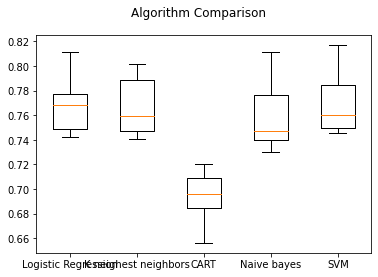

In [0]:
#@title
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC


# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression(C=1,max_iter=1000)))
models.append(('K neighest neighbors', KNeighborsClassifier(n_neighbors=100)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Naive bayes', MultinomialNB()))
models.append(('SVM', SVC(C=1)))
# evaluate each model in turn
results = []
names = []
scoring = 'f1'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_d, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

SVM is giving better baseline performance so we will test svm by tuning its parameters 

Performed Stratified shuffle split which preserve the folds are made by preserving the percentage of samples for each class.

Performed grid search cv which returns the best performing parameters

In [0]:
#@title
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

scoring = {'accuracy': make_scorer(accuracy_score),'f1': make_scorer(f1_score)}

folds = StratifiedShuffleSplit(n_splits=5, random_state=0)
# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': ['scale'],'kernel':['rbf','sigmoid'],
                     'C': [0.5,0.8,1]}]


# specify model
model = SVC(cache_size=1000)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model,
                        refit='f1', 
                        param_grid = hyper_params, 
                        scoring= scoring,
                        cv = folds, 
                        verbose = True,
                        return_train_score=True,n_jobs=-1)         

# fit the model
model_cv.fit(X_d, y)

#next cell
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

#next cell
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

#next cell
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished


The best test score is 0.7832481006398921 corresponding to hyperparameters {'C': 0.5, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [0]:
#@title
pd.set_option('max_rows', 200)
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1
0,5.838935,0.063721,0.584505,0.013734,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",0.637571,0.641366,0.626186,0.641366,0.626186,0.634535,0.006956,6,0.713020,0.705845,0.714286,0.707111,0.714497,0.710952,0.003709,0.771804,0.773653,0.765755,0.774194,0.765197,0.770120,0.003878,5,0.810321,0.806550,0.810999,0.807169,0.811165,0.809241,0.001975
1,4.687108,0.024674,0.448865,0.001914,0.5,scale,sigmoid,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'sigmoid'}",0.679317,0.681214,0.669829,0.702087,0.658444,0.678178,0.014431,3,0.737919,0.734754,0.739185,0.736864,0.744672,0.738679,0.003330,0.784163,0.784615,0.777494,0.798976,0.770992,0.783248,0.009310,1,0.820260,0.818798,0.820870,0.819876,0.824179,0.820797,0.001821
2,5.796363,0.037190,0.591920,0.012190,0.8,scale,rbf,"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.675522,0.677419,0.641366,0.677419,0.658444,0.666034,0.014250,5,0.910530,0.912429,0.917493,0.914328,0.912218,0.913399,0.002375,0.785445,0.787500,0.763454,0.785354,0.776119,0.779575,0.008972,3,0.931877,0.933269,0.936885,0.934537,0.933119,0.933937,0.001698
3,4.695169,0.028619,0.438231,0.004734,0.8,scale,sigmoid,"{'C': 0.8, 'gamma': 'scale', 'kernel': 'sigmoid'}",0.692600,0.703985,0.666034,0.702087,0.652751,0.683491,0.020486,1,0.791728,0.791306,0.796793,0.793416,0.795315,0.793712,0.002091,0.781671,0.791444,0.762803,0.786974,0.757616,0.776102,0.013440,4,0.849520,0.849399,0.852187,0.850054,0.851863,0.850604,0.001185
4,5.633044,0.023773,0.585415,0.005356,1,scale,rbf,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.685009,0.681214,0.662239,0.702087,0.664137,0.678937,0.014669,2,0.962439,0.960118,0.960962,0.962439,0.961384,0.961469,0.000891,0.782723,0.781250,0.768831,0.795839,0.771613,0.780051,0.009538,2,0.970204,0.968410,0.969089,0.970194,0.969424,0.969464,0.000683
5,4.666066,0.045610,0.435503,0.010231,1,scale,sigmoid,"{'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}",0.671727,0.709677,0.654649,0.692600,0.650854,0.675901,0.022433,4,0.812197,0.812197,0.816206,0.817050,0.815151,0.814560,0.002021,0.762036,0.790698,0.747922,0.775623,0.750000,0.765256,0.016114,6,0.861500,0.861154,0.864055,0.864213,0.863168,0.862818,0.001273


Sigmoid kernel with C=1 and gamma = scale gave the best performance

In [0]:
#@title
from sklearn.svm import SVC
# model with optimal hyperparameters
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# model
model = SVC(C=0.5, kernel="sigmoid")

model.fit(X_data, y_train)
y_pred = model.predict(X_val)

# metrics
y_true=y_val
print("f1_score", metrics.f1_score(y_true, y_pred), "\n")
print("accuracy", metrics.accuracy_score(y_true, y_pred), "\n")
print("precision", metrics.precision_score(y_true, y_pred), "\n")
print("recall", metrics.precision_score(y_true, y_pred), "\n")
tn, fp, fn, tp = metrics.confusion_matrix(y_true,y_pred).ravel()
print("non hate but falsely predicted hate:",fn)
print("non hate and Truely predicted non hate:",tp)
print("hate and falsely predicted non hate:",fp)
print("hate and Truely predicted hate:",tn)


f1_score 0.7806096951524238 

accuracy 0.6666666666666666 

precision 0.6563025210084034 

recall 0.6563025210084034 

non hate but falsely predicted hate: 30
non hate and Truely predicted non hate: 781
hate and falsely predicted non hate: 409
hate and Truely predicted hate: 97


In [0]:
#@title
model.fit(X_d, y)
y_pred = model.predict(X_te)

In [0]:
#@title
test_samples=test['text'].values.tolist()

In [0]:
#@title
Out=pd.DataFrame({"labels":y_pred})
Out.to_csv('finalsvmsubmission.csv')